In [ ]:
import os
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
from tqdm import tqdm
import logging
import seaborn as sn

from rsna_dataloader import *


In [ ]:
class CustomResNet(nn.Module):
    def __init__(self, out_features=512, pretrained_weights=None):
        super(CustomResNet, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        if pretrained_weights:
            self.model.load_state_dict(torch.load(pretrained_weights))
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features=num_ftrs, out_features=out_features)

    def forward(self, x):
        return self.model(x)


class CustomLSTM(nn.Module):
    hidden_size = 256
    num_layers = 2

    def __init__(self, num_classes=5 * 2, drop_rate=0.2, resnet_weights=None):
        super(CustomLSTM, self).__init__()
        self.cnn = CustomResNet(pretrained_weights=resnet_weights)
        self.lstm = nn.LSTM(input_size=512, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, bidirectional=True)
        self.head = nn.Sequential(
            nn.Linear(256, 128),
            # nn.BatchNorm1d(256),
            nn.Dropout(drop_rate),
            nn.LeakyReLU(0.1),
            nn.Linear(128, num_classes),
        )
    def forward(self, x_3d):
        hidden = None

        # Iterate over each frame of a video in a video of batch * frames * channels * height * width
        for t in range(x_3d.size(1)):
            x = self.cnn(x_3d[:, t])
            # Pass latent representation of frame through lstm and update hidden state
            out, hidden = self.lstm(x.unsqueeze(0), hidden)

            # Get the last hidden state (hidden is a tuple with both hidden and cell state in it)
        x = self.head(hidden[0][-1])

        return x


In [ ]:
model = torch.load("../models/resnet18_lstm_t2stir.pt")

In [ ]:
transform_val = transforms.Compose([
    transforms.Lambda(lambda x: (x * 255).astype(np.uint8)),  # Convert back to uint8 for PIL
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

In [ ]:
data_basepath = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
training_data = retrieve_training_data(data_basepath)

In [ ]:
test_loader = create_series_level_test_datasets_and_loaders(training_data, "Sagittal T2/STIR", transform_val, data_basepath + "train_images")

In [ ]:
label_map = {'normal_mild': 0, 'moderate': 1, 'severe': 2}
def get_output_class(val):
    if val <= 0.33:
        return 0
    elif val <= 0.66:
        return 1
    else:
        return 2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
preds = []
for image, label in tqdm(test_loader):
    image = image.to(device)
    preds.append((model(image).detach().cpu().numpy(), label.numpy()))
    if len(preds) == 100:
        break

In [ ]:
preds

In [ ]:
def scores_to_classes(arr):
    ret = []
    for i in range(0, len(arr)-1, 2):
        if arr[i] == 0:
            ret.append(0)
        elif arr[i] == 1:
            ret.append(2)
        else:
            ret.append(1)
            
    return ret

In [ ]:
pred_classes = [(scores_to_classes(e[0][0]), scores_to_classes(e[1][0])) for e in preds]

In [ ]:
pred_classes_0 = [e[0][4] for e in pred_classes]
pred_classes_0_ = [e[1][4] for e in pred_classes]

In [ ]:
cf_matrix = confusion_matrix(pred_classes_0, pred_classes_0_)
df_cm = pd.DataFrame(cf_matrix)
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True)
plt.show()


In [ ]:
training_data

In [ ]:
training_data[training_data["condition"] == "Spinal Canal Stenosis"].groupby(["severity"]).count()

In [ ]:
pretrained_coord_path = "C:\\Users\Victor\\Documents\\python-doodles\\models\\resnet34_cnn_coordinates_t2stir\\resnet34_cnn_coordinates_t2stir_15.pt"

In [ ]:
import torch.nn as nn
from transformers import AutoModelForImageClassification

class CoordinateDetector2D(nn.Module):
    def __init__(self, out_features=10, pretrained_weights=None):
        super(CoordinateDetector2D, self).__init__()
        self.model = AutoModelForImageClassification.from_pretrained("BehradG/resnet-18-MRI-Brain", torchscript=True)
        if pretrained_weights:
            self.model.load_state_dict(torch.load(pretrained_weights))
        self.model.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=out_features),
        )

    def forward(self, x):
        return self.model(x)[0]


In [ ]:
import torch

coordinate_model = torch.load(pretrained_coord_path)

In [ ]:
from rsna_dataloader import *

In [ ]:
from torchvision import transforms
from torchvision.transforms import v2

data_basepath = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
training_data = retrieve_training_data(data_basepath)

transform_train = TrainingTransform()

transform_val = ValidationTransform()

In [ ]:
trainloader, valloader, trainset, valset = create_coordinate_datasets_and_loaders(training_data,
                                                                                 "Sagittal T2/STIR",
                                                                                 transform_train,
                                                                                 transform_val,
                                                                                 data_basepath + "train_images",
                                                                                 num_workers=0,
                                                                                 batch_size=1)


In [ ]:
def show_inference_vs_label_for_index(index: int):
    image, label = trainset[index]
    f, axarr = plt.subplots(1, 2)
    
    inferred = coordinate_model(image.unsqueeze(0).to("cuda")).detach().cpu()
    x_ = [inferred[i] for i in range(0, len(inferred), 2)]
    y_ = [inferred[i] for i in range(1, len(inferred), 2)]
    
    axarr[0].scatter(x_, y_) 
    axarr[0].imshow(image.squeeze(0)[0])
    
    x = [label[i] for i in range(0, len(label), 2)]
    y = [label[i] for i in range(1, len(label), 2)]
    
    plt.scatter(x, y)
    axarr[1].imshow(image.squeeze(0)[0])

show_inference_vs_label_for_index(15)

In [ ]:
from torchvision.ops import distance_box_iou_loss, generalized_box_iou_loss, complete_box_iou_loss

class DistanceBoxIOULoss(nn.Module):
    def forward(self, inferred, target):
        inferred_boxes = get_bounding_boxes_for_label(inferred).reshape(-1, 4)
        target_boxes = get_bounding_boxes_for_label(target).reshape(-1, 4)

        return complete_box_iou_loss(inferred_boxes, target_boxes, reduction='mean')


In [ ]:
loss = DistanceBoxIOULoss()

In [ ]:
from tqdm import tqdm

losses = []
for i, val in tqdm(enumerate(valset)):
    try:
        image, label = val
        inferred = coordinate_model(image.unsqueeze(0).to("cuda")).detach().cpu()
        losses.append((loss(inferred, label), i))
    except Exception as e:
        continue

In [ ]:
sorted_losses = sorted(losses, key=lambda x: x[0], reverse=True)
sorted_losses[:10]

In [ ]:
show_inference_vs_label_for_index(1330)

In [ ]:
import torch
import torch.nn as nn

loss = nn.BCELoss()

In [ ]:
logit = torch.tensor([[0.0,1.0,1.0], [0.0,1.0,0.0]])
target = torch.tensor([[1.0,1.0,0.0], [0.0,1.0,1.0]])
loss(logit, target)

In [ ]:
from rsna_dataloader import *

trainloader, valloader, trainset, valset = create_datasets_and_loaders(training_data,
                                                                         "Sagittal T2/STIR",
                                                                         transform_train,
                                                                         transform_val,
                                                                         num_workers=0,
                                                                         split_factor=0.1,
                                                                         batch_size=1)


In [ ]:
trainset.dataframe.describe()

In [ ]:
valset.dataframe.describe()

In [ ]:
import timm
import torch.nn as nn
import torch

class VIT_Model(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(VIT_Model, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            num_classes=15,
            features_only=False,
            drop_rate=0.1,
            drop_path_rate=0.1,
            pretrained=pretrained
        )

    def forward(self, x):
        return self.encoder(x).reshape((-1, 5, 3))


In [ ]:
import torch.nn as nn

class VIT_Model_25D(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(VIT_Model_25D, self).__init__()

        self.num_classes = CONFIG["out_dim"] * CONFIG["n_levels"]
        self.encoder = timm.create_model(
            backbone,
            num_classes=self.num_classes,
            features_only=False,
            drop_rate=CONFIG["drop_rate"],
            drop_path_rate=CONFIG["drop_path_rate"],
            pretrained=pretrained
        )
        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'vit' in backbone:
            hdim = 576
            self.encoder.head.fc = nn.Identity()
        self.attention_layer = nn.Sequential(
            # !TODO: Need to figure this one out
            nn.LayerNorm(hdim, eps=1e-05, elementwise_affine=True),
            nn.Dropout(p=CONFIG["drop_rate"], inplace=True),
            nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=576, nhead=8), num_layers=2),
        )
        self.head = NormMLPClassifierHead(self.num_classes)

    def forward(self, x):
        feat = self.encoder(x.squeeze(0))
        feat = self.attention_layer(feat.unsqueeze(0))
        # BERT-like approach
        feat = self.head(feat[:, 0])

        # !TODO: This is likely incorrect
        return feat.reshape((-1, CONFIG["n_levels"], CONFIG["out_dim"]))

class NormMLPClassifierHead(nn.Module):
    def __init__(self, out_dim):
        super(NormMLPClassifierHead, self).__init__()

        self.out_dim = out_dim
        self.head = nn.Sequential(
            nn.LayerNorm(576, eps=1e-05, elementwise_affine=True),
            # nn.Flatten(start_dim=1, end_dim=-1),
            nn.Dropout(p=CONFIG["drop_rate"], inplace=True),
            nn.Linear(in_features=576, out_features=15, bias=True),
            # nn.Softmax()
        )

    def forward(self, x):
        return self.head(x)


In [ ]:
import torch 

inference_model = torch.load("../models/tiny_vit_21m_384_transformer_t2stir/tiny_vit_21m_384_transformer_t2stir_15.pt")
inference_model.eval()

In [ ]:
inference_model = inference_model.to("cuda")
CONFIG = dict(
    project_name="PL-RSNA-2024-Lumbar-Spine-Classification",
    artifact_name="rsnaEffNetModel",
    load_kernel=None,
    load_last=True,
    n_folds=5,
    n_levels=5,
    backbone="tiny_vit_21m_384",
    img_size=(384, 384),
    n_slice_per_c=16,
    in_chans=1,
    drop_rate=0.1,
    drop_rate_last=0.3,
    drop_path_rate=0.,
    p_mixup=0.5,
    p_rand_order_v1=0.2,
    lr=1e-3,
    out_dim=3,
    epochs=200,
    batch_size=8,
    device=torch.device("cuda") if torch.cuda.is_available() else "cpu",
    seed=2024
)

In [1]:
from rsna_dataloader import *

data_basepath = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
training_data = retrieve_training_data(data_basepath)

transform_train = TrainingTransform(image_size=(384,384))
transform_val = ValidationTransform(image_size=(384,384))

trainloader, valloader, trainset, valset = create_series_level_datasets_and_loaders(training_data,
                                                                         "Sagittal T2/STIR",
                                                                         transform_train,
                                                                         transform_val,
                                                                         base_path= data_basepath + "train_images",
                                                                         num_workers=0,
                                                                         split_factor=0.1,
                                                                         batch_size=1)


In [ ]:
from tqdm import tqdm

inferred = []
target = []

with torch.no_grad():
    for image, label in tqdm(valloader):
        target.append(label.detach())
        inferred.append(inference_model(image.to("cuda")).detach())

In [ ]:
inferred_l = [[np.argmax(e_) for e_ in e.detach().cpu()[0]] for e in inferred]

In [ ]:
target_l = [[np.argmax(e_) for e_ in e.detach().cpu()[0]] for e in target]

In [ ]:
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [ ]:
nn.Sigmoid()(inferred[1])


In [ ]:
inference_model.parameters().__next__()[47]


In [ ]:

from operator import truediv

precisions = []
recalls = []

fig, ax = plt.subplots(nrows=5)
for i in range(5):
    target_ = [e[i] for e in target_l]
    inferred_ = [e[i] for e in inferred_l]

    cf_matrix = confusion_matrix(target_, inferred_)
    sn.heatmap(cf_matrix / np.sum(cf_matrix), ax=ax[i], annot=True, fmt='.3%')
    
    true_pos = np.diag(cf_matrix) 
    prec = list(map(truediv, true_pos, np.sum(cf_matrix, axis=0)))
    rec = list(map(truediv, true_pos, np.sum(cf_matrix, axis=1)))
    
    precisions.append(prec)
    recalls.append(rec)
    
plt.show()

In [ ]:
inferred[0]

In [ ]:
fig, ax = plt.subplots(nrows=5)
for i in range(5):
    ax[i].set(ylim=(0, 1))
    sn.barplot(x=range(3), y=precisions[i], ax=ax[i])
    sn.barplot(x=range(3,6), y=recalls[i], ax=ax[i])
plt.show()

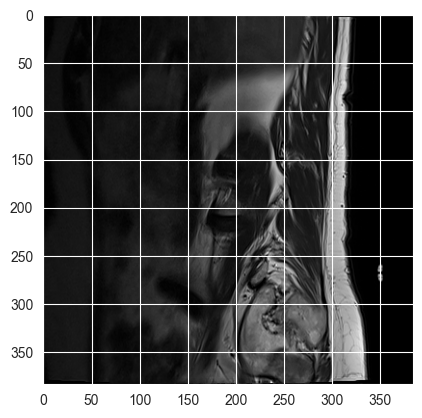

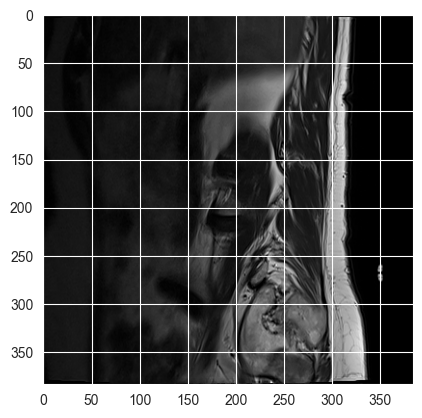

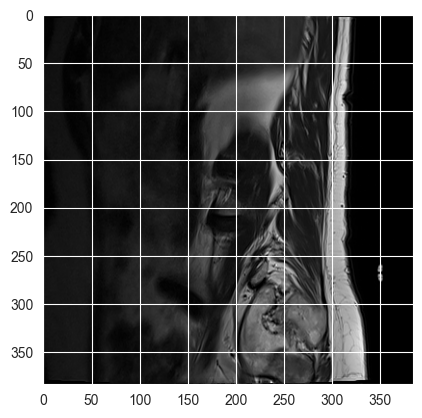

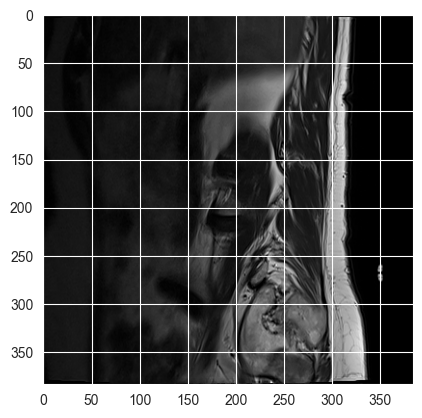

KeyboardInterrupt: 

In [2]:

def show_images_for_series(index: int, dataset):
    images, label = dataset[index]
    f, axarr = plt.subplots(1, len(images), figsize = (348,348))

    for i, pic in enumerate(images):
        axarr[i].imshow(np.moveaxis(pic, 0, -1))

show_images_for_series(100, trainset)

In [ ]:
(training_data[["severity", "level"]].value_counts() / training_data[["level"]].value_counts()).groupby(["level","severity"]).mean().head(20)

In [ ]:
(valset.dataframe[["severity", "level"]].value_counts() / valset.dataframe[["level"]].value_counts())


In [ ]:
training_data["series_description"]

In [ ]:
model_scripted = torch.jit.script(inference_model)# Export to TorchScript

model_scripted.save('efficientnetv2_b3_lstm_t2stir_109.pt') # Save

In [ ]:
training_data.columns

In [ ]:
import timm

timm.list_models("*efficientnet*")